**Stage 1 - Validation**

In [1]:
# @title 1. Install Dependencies
import os
import sys

# 1.1 Force Upgrade Libraries
print("Installing libraries...")
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers peft accelerate
!pip install -q moderngl
!apt-get install -y libgl1-mesa-glx > /dev/null

# 1.2 Restart Check
try:
    import bitsandbytes
    from transformers.utils import is_bitsandbytes_available
    if not is_bitsandbytes_available():
        print("\n" + "="*60)
        print("  PLEASE RESTART RUNTIME (Runtime > Restart Session)")
        print("Then run this cell again.")
        print("="*60 + "\n")
    else:
        print("  Environment Ready.")
except ImportError:
    pass

Installing libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 5.0 MB/s eta 0:00:00
  Environment Ready.


In [2]:
# @title 2. Load Model & Adapter
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from peft import PeftModel
import os
import sys
import importlib.util

# 2.1 Configuration
PROJECT_ROOT = '/content/drive/MyDrive/projects/EarthShader'
ADAPTER_PATH = os.path.join(PROJECT_ROOT, 'checkpoints/stage1_final')
LIB_DIR = os.path.join(PROJECT_ROOT, 'lib')

# 2.2 Mount Drive
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2.3 Setup Renderer
sys.path.append(PROJECT_ROOT)
if LIB_DIR not in sys.path:
    sys.path.insert(0, LIB_DIR)

try:
    from gl_renderer import ShaderRenderer
    # Initialize renderer once to hold the context
    renderer = ShaderRenderer(width=256, height=256)
    print("[SUCCESS] Renderer ready.")
except ImportError:
    spec = importlib.util.spec_from_file_location("gl_renderer", os.path.join(LIB_DIR, "gl_renderer.py"))
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    renderer = mod.ShaderRenderer(width=256, height=256)
    print("[SUCCESS] Renderer ready (Direct Load).")

# 2.4 Load Model
print(f"⏳ Loading Adapter from: {ADAPTER_PATH}...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load Base
base_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
)

# Load Adapter
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

print("[SUCCESS] Model Loaded Successfully!")

Mounted at /content/drive
[SUCCESS] Renderer ready.
⏳ Loading Adapter from: /content/drive/MyDrive/projects/EarthShader/checkpoints/stage1_final...


config.json: 0.00B [00:00, ?B/s]

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/730 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

[SUCCESS] Model Loaded Successfully!


Running Inference on 3 Random Samples...


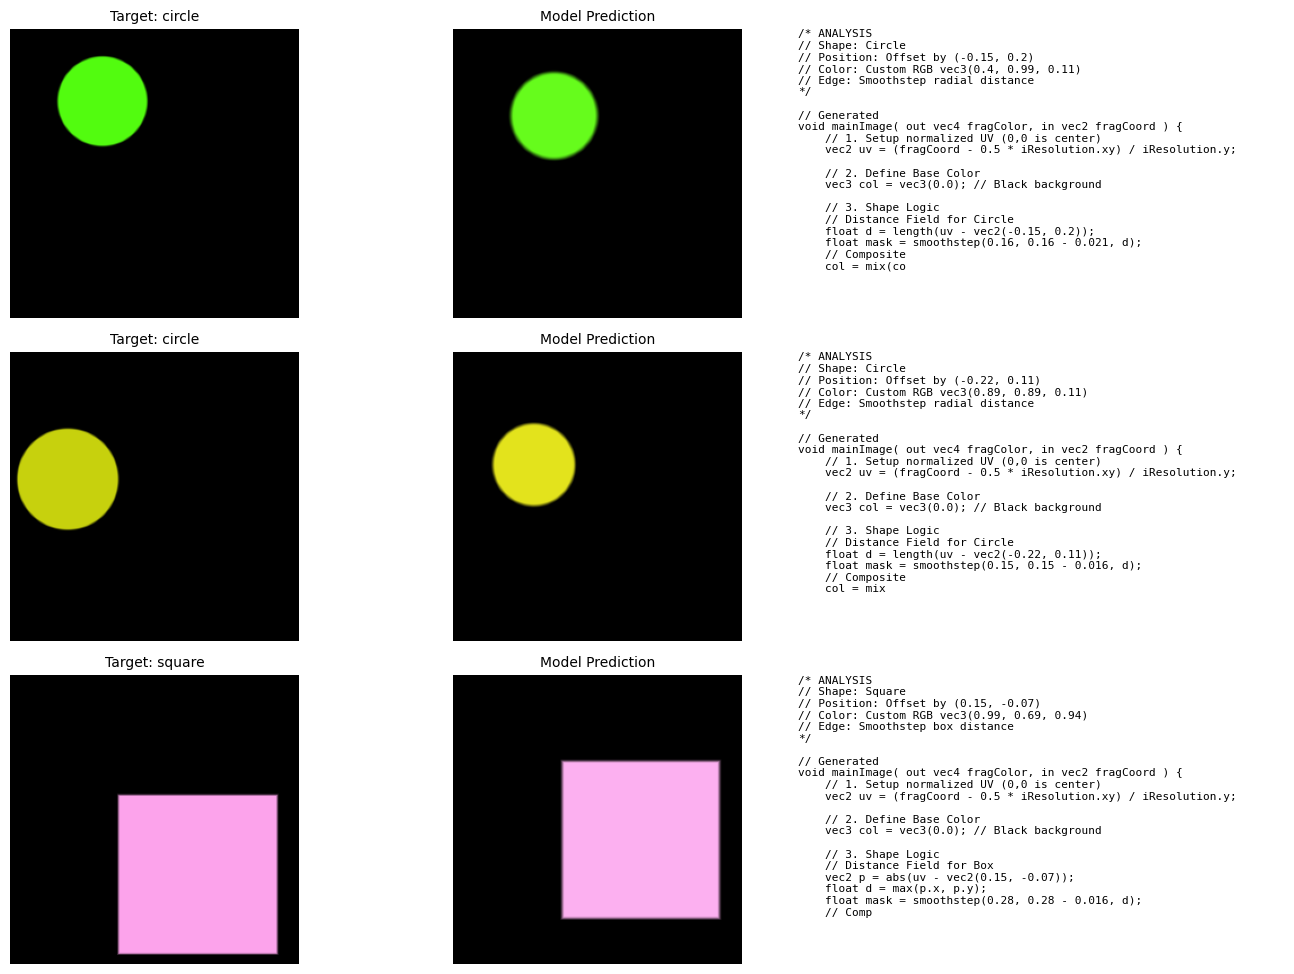

In [3]:
# @title 3. Generate & Validate Samples (Batched Speedup)
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os

# 3.1 Helpers
def extract_code(text):
    if "// GLSL CODE" in text:
        return text.split("// GLSL CODE")[1].strip()
    if "```glsl" in text:
        return text.split("```glsl")[1].split("```")[0].strip()
    return text

def generate_validation_sample():
    """Generates a random puzzle (GT Code) to test the model"""
    shape_type = random.choice(['circle', 'square', 'ring'])
    pos_x = round(random.uniform(-0.3, 0.3), 2)
    pos_y = round(random.uniform(-0.3, 0.3), 2)
    size = round(random.uniform(0.1, 0.4), 2)
    r, g, b = round(random.random(),2), round(random.random(),2), round(random.random(),2)
    color = f"vec3({r}, {g}, {b})"

    code = f"""void mainImage( out vec4 fragColor, in vec2 fragCoord ) {{
    vec2 uv = (fragCoord - 0.5 * iResolution.xy) / iResolution.y;
    vec3 col = vec3(0.0);
    """
    if shape_type == 'circle':
        code += f"    float d = length(uv - vec2({pos_x}, {pos_y}));\n"
        code += f"    float mask = smoothstep({size}, {size}-0.01, d);\n"
    elif shape_type == 'square':
        code += f"    vec2 p = abs(uv - vec2({pos_x}, {pos_y}));\n"
        code += f"    float d = max(p.x, p.y);\n"
        code += f"    float mask = smoothstep({size}, {size}-0.01, d);\n"
    elif shape_type == 'ring':
        code += f"    float d = abs(length(uv - vec2({pos_x}, {pos_y})) - {size});\n"
        code += f"    float mask = smoothstep(0.05, 0.04, d);\n"

    code += f"    col = mix(col, {color}, mask);\n"
    code += "    fragColor = vec4(col, 1.0);\n}"
    return code, shape_type

# 3.2 BATCHED Inference Loop
print("Generating 3 samples in parallel...")

# A. Prepare Batch Data
gt_images = []
conversations = []
shape_names = []

for _ in range(3):
    # 1. Create the Puzzle
    gt_code, shape_name = generate_validation_sample()
    renderer.render(gt_code, "temp_gt.png")
    img = Image.open("temp_gt.png").convert("RGB")

    gt_images.append(img)
    shape_names.append(shape_name)

    # 2. Prepare the Question (Image Only)
    conversations.append([
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img}, # Pass PIL Image directly
                {"type": "text", "text": "Reverse engineer the GLSL shader code for this texture. Include analysis."}
            ]
        }
    ])

# B. Process Batch (One massive processor call)
text_prompts = [processor.apply_chat_template(convo, add_generation_prompt=True) for convo in conversations]
inputs = processor(
    text=text_prompts,
    images=gt_images,
    padding=True,
    return_tensors="pt"
).to(model.device)

# C. Generate Batch (One massive GPU call)
print("Running Inference on GPU (Batched)...")
with torch.no_grad():
    output_ids = model.generate(**inputs, max_new_tokens=512)

# D. Decode Batch
generated_ids = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, output_ids)]
output_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

# E. Visualize Results
plt.figure(figsize=(18, 12))
for i in range(3):
    # Extract & Render
    pred_code = extract_code(output_texts[i])
    renderer.render(pred_code, f"temp_pred_{i}.png")

    if os.path.exists(f"temp_pred_{i}.png"):
        pred_image = Image.open(f"temp_pred_{i}.png")
    else:
        pred_image = Image.new("RGB", (256, 256), (255, 0, 0))

    # Plot GT
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(gt_images[i])
    plt.title(f"Target: {shape_names[i]}", fontsize=10)
    plt.axis('off')

    # Plot Pred
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(pred_image)
    plt.title("Model Prediction", fontsize=10)
    plt.axis('off')

    # Plot Code
    ax = plt.subplot(3, 3, i*3 + 3)
    clean_code = pred_code.replace("void mainImage", "// Generated\nvoid mainImage")
    plt.text(0, 1, clean_code[:600], family='monospace', fontsize=8, verticalalignment='top')
    plt.axis('off')

plt.tight_layout()
plt.show()